# Importing Packages

In [36]:
# General utilities
import numpy as np
import pandas as pd
import random

# Data Visualization
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import font_manager
from matplotlib.pyplot import figure

# Data Preprocessing
# from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from torchvision import transforms

# Model Training
import torch
import torch.nn as nn
from torch.optim import Adam
from torch.optim.lr_scheduler import StepLR
from tqdm import tqdm
from copy import deepcopy

# Testing
from sklearn.metrics import accuracy_score

In [37]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
display(device)

device(type='cuda')

adding fonts to matplotlib in order to display special characters

In [38]:
fonts_added = 0
font_kannada_added = False
font_heiti_added = False
for font in font_manager.findSystemFonts():
    if "kannada" in font.lower():
        print("Adding \'Noto Sans Kannada\' font family")
        font_manager.fontManager.addfont(font)
        font_kannada_added = True
    elif "heiti" in font.lower():
        print("Adding \'Heiti TC\' font family")
        font_manager.fontManager.addfont(font)
        font_heiti_added = True
if not font_kannada_added:
    print("Warning: Figures might not be rendered properly because your system does not have the \'Noto Sans Kannada\' " + 
          "font family. Go to https://fonts.google.com/noto/specimen/Noto+Sans+Kannada to download it and " +
          "follow the instructions at https://support.microsoft.com/en-us/office/add-a-font-b7c5f17c-4426-4b53-967f-455339c564c1")
if not font_heiti_added:
    print("Warning: Figures might not be rendered properly because your system does not have the \'Heiti TC\' " +
          "font family. Go to https://maisfontes.com/?fnome=Heiti+TC to download it and follow the instructions " +
          "at https://support.microsoft.com/en-us/office/add-a-font-b7c5f17c-4426-4b53-967f-455339c564c1")
matplotlib.rcParams['font.family'] = ['Noto Sans Kannada', 'Heiti TC']

Adding 'Noto Sans Kannada' font family
Adding 'Heiti TC' font family


# Defining Hyperparameters

In [39]:
# TODO: Tune these hyperparameters
config = {
    # DO NOT MODIFY THIS
    'labelToClass' : {
        # MNIST
        '0': '0', '1': '1', '2': '2', '3': '3', '4': '4', '5': '5', '6': '6', '7': '7', '8': '8', '9': '9',
        # Fashion
        '10': 'T-shirt/top', '11': 'Trouser', '12': 'Pullover', '13': 'Dress', '14': 'Coat', '15': 'Sandal', '16': 'Shirt', '17': 'Sneaker', '18': 'Bag', '19': 'Ankle boot',
        # Kannada
        '20': "sonne (೦)", '21': "ondu (೧)", '22': 'eraḍu (೨)', '23': 'mūru (೩)', '24': 'nālku (೪)', '25': 'aidu (೫)', '26': 'āru (೬)', '27': 'ēḷu (೭)', '28': 'enṭu (೮)', '29': 'oṃbattu (೯)',
        # Chinese
        '30': '零', '31': '一', '32': '二', '33': '三', '34': '四', '35': '五', '36': '六', '37': '七', '38': '八', '39': '九', '40':'十', '41': '百', '42': '千', '43': '万', '44': '亿', 
    },

    # Things below this can be tuned
    'transform': transforms.Compose([
        transforms.Resize(64),
        transforms.CenterCrop(64),
        transforms.Normalize((0), (1))
    ]),
    'lr': 0.005,
    'weight_decay': 1e-5,
    'max_epochs': 10,
    'optim': Adam,
    'batch_size': 512,
    # 'random_state': 399,
    'random_state': None,
}

# Data Preprocessing

### Reading Files

In [56]:
mnist_train = pd.read_csv("data/MNIST/train.csv")
mnist_test = pd.read_csv("data/MNIST/test.csv")

fashion_train = pd.read_csv("data/fashion-mnist/train.csv")
fashion_test = pd.read_csv("data/fashion-mnist/test.csv")

kannada = pd.read_csv("data/kannada-mnist/traintest.csv")
kannada_train, kannada_test = train_test_split(kannada, test_size=0.1)
# because the Kannada competition only allows submissions via notebook, we need to find an alternative

chinese = pd.read_csv("data/chinese-mnist/traintest.csv")
chinese_train, chinese_test = train_test_split(chinese, test_size=0.1)

Note: The test set for MNIST does not have labels, so we'll need to make and submit predictions to Kaggle. To keep our metrics across all datasets fair, we can only use accuracy to evaluate models.

### Preparing Datasets

In [41]:
# fix column names for fashion_train and fashion_train because their pixels start at 1 instead of 0
fashion_train.columns = mnist_train.columns
fashion_train['label'] = fashion_train['label'] + 10
fashion_test['label'] = fashion_test['label'] + 10
fashion_test_labels = fashion_test['label']
fashion_test = fashion_test.drop(columns="label")
fashion_test.columns = mnist_test.columns

kannada_train['label'] = kannada_train['label'] + 20
kannada_test_labels = kannada_test['label'] + 20
kannada_test = kannada_test.drop(columns={'label'})

chinese_labelEncoder = {0: 30, 1: 31, 2: 32, 3: 33, 4: 34, 5: 35, 6: 36, 7: 37, 8: 38, 9: 39, 10: 40, 100: 41, 1000: 42, 10000:43, 100000000:44}
chinese_train['label'] = chinese_train['label'].apply(lambda x: chinese_labelEncoder[x])
chinese_train = chinese_train.drop(columns={'character'})
chinese_test_labels = chinese_test['label'].apply(lambda x: chinese_labelEncoder[x])
chinese_test = chinese_test.drop(columns={'label', 'character'})

### Making the Dataset

In [42]:
class MNIST_Datasets(Dataset):
    def __init__(self, dataframes, mode, target_feat='label'):
        self.mode = mode
        initialized = False

        for dataframe in dataframes:
            # shuffle the dataframe because some of these datasets are organized
            dataframe = dataframe.sample(frac = 1, random_state=config['random_state'])
            if mode == 'train':
                indices = [i for i in range(len(dataframe)) if i % 9 != 0]
            elif mode == 'val':
                indices = [i for i in range(len(dataframe)) if i % 9 == 0]
            dataframe = dataframe.iloc[indices]

            X = dataframe.drop(columns=target_feat).values
            img_shape = (int) (np.sqrt(X.shape[1]))
            X = torch.tensor(X.reshape(-1, 1, img_shape, img_shape), dtype=torch.float32)
            X_trans = config['transform'](X)
            y = torch.tensor(dataframe[target_feat].values, dtype=torch.long)
            if not initialized:
                initialized = True
                self.data = X_trans
                self.target = y
            else:
                self.data = torch.cat((self.data, X_trans))
                self.target = torch.cat((self.target, y))
                
        self.dim = self.data.shape[1]
        print('Finished reading the {} set of Dataset ({} samples found, each dim = {})'.format(mode, len(self.data), self.dim))
        print("\tdata.shape = ", self.data.shape)
        print("\ttarget.shape = ", self.target.shape)


    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        return self.data[index], self.target[index]

In [43]:
print(f"The datasets have a total of {mnist_train.shape[0] + fashion_train.shape[0] + kannada_train.shape[0] + chinese_train.shape[0]} samples")
trainset = MNIST_Datasets(dataframes=[mnist_train, fashion_train, kannada_train, chinese_train], mode='train')
valset = MNIST_Datasets(dataframes=[mnist_train, fashion_train, kannada_train, chinese_train], mode='val')

train_loader = DataLoader(trainset, batch_size=config['batch_size'], shuffle=True)
val_loader = DataLoader(valset, batch_size=config['batch_size'], shuffle=False)

The datasets have a total of 169500 samples
Finished reading the train set of Dataset (150666 samples found, each dim = 1)
	data.shape =  torch.Size([150666, 1, 64, 64])
	target.shape =  torch.Size([150666])
Finished reading the val set of Dataset (18834 samples found, each dim = 1)
	data.shape =  torch.Size([18834, 1, 64, 64])
	target.shape =  torch.Size([18834])


### Train/Val/Test Breakdown

| Dataset | Train | Validation | Test |
| --- | --- | --- | --- |
| MNIST | 53.333% | 6.667% | 40% |
| Fashion | 76.19% | 9.524% | 14.286% |
| Kannada | 80% | 10% | 10% |
| Chinese | 80% | 10% | 10% |

# Data Analysis

### Visualizing the dataset

In [44]:
def grid_display(images, y_true, y_pred=None, num_rows=2, num_cols=5):
    num = num_rows*num_cols
    rand_indices = random.sample(range(0, len(images)), num)
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(2*num_cols,2*num_rows))
    for i in range(num):
        ax = axes[i // num_cols, i % num_cols]
        ax.imshow(images[rand_indices[i]])
        # ax.imshow(images[rand_indices[i]], cmap='gray_r')
        label_true = config['labelToClass'][str(int(y_true[rand_indices[i]]))]
        if y_pred is None:
            ax.set_title(f"Label: {label_true}")
        else:
            label_pred = config['labelToClass'][str(int(y_pred[rand_indices[i]]))]
            ax.set_title(f"Label: {label_true}",
                fontdict={'color': 'green' if label_true == label_pred else 'red'})
    plt.tight_layout()
    plt.show()

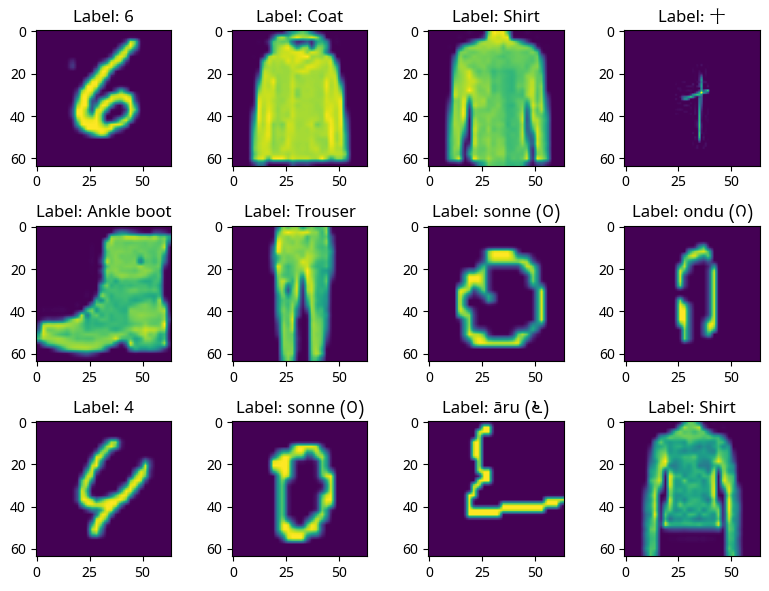

In [45]:
dataiter = iter(train_loader)
data, target = next(dataiter)
grid_display(data.reshape(-1, data.shape[2], data.shape[3]), target, num_rows=3, num_cols=4)

### **TODO**: Do some more data preprocessing

# Training

In [46]:
# TODO: Tune this modela architecture
class Net(nn.Module):
    def __init__(self, num_classes=45):
        super(Net, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 28, kernel_size=5, stride=2, padding=0),
            nn.BatchNorm2d(28),
            nn.LeakyReLU(),
            nn.MaxPool2d(kernel_size = 2)
        )
        self.layer2 = nn.Sequential(
            nn.Conv2d(28, 32, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(),
            nn.MaxPool2d(kernel_size = 2)
        )
        self.layer3 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU()
        )
        self.fc1 = nn.Sequential(
            nn.Dropout(0.25, inplace=True),
            nn.Linear(64*7*7, 1024),
            nn.BatchNorm1d(1024),
            nn.LeakyReLU()
        )
        self.fc2 = nn.Sequential(
            nn.Dropout(0.25, inplace=True),
            nn.Linear(1024, 128),
            nn.BatchNorm1d(128),
            nn.LeakyReLU()
        )
        self.fc3 = nn.Sequential(
            nn.Linear(128, num_classes),
        )

        self.criterion = nn.CrossEntropyLoss()
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = torch.flatten(out, 1)
        out = self.fc1(out)
        out = self.fc2(out)
        return out

    def cal_loss(self, pred, target):
        return self.criterion(pred, target)
    
model = Net().to(device)

In [47]:
optimizer = Adam(model.parameters(), lr=config['lr'], weight_decay=config['weight_decay'])
# TODO: try to tune this learning rate scheduler. There are other schedulers, but this one multiplies the learning rate by
# gamma after step_size=2 epochs.
lr_scheduler = StepLR(optimizer, step_size=2, gamma=0.7)

In [48]:
best_val_acc = -1000
best_val_model = None
acc_record = {'train': [], 'val': []}
for epoch in range(config['max_epochs']):  
    running_loss = 0.0
    running_acc = 0
    running_size = 0
    # this shows a progress bar during training, which is valuable due to how long it takes to train
    with tqdm(train_loader, unit='batch') as tepoch:
        model.train()
        for (data, target) in tepoch:
            tepoch.set_description("Epoch: {epoch:>2}".format(epoch=epoch+1))
            data, target = data.to(device), target.to(device)

            optimizer.zero_grad()
            outputs = model(data)
            loss = model.cal_loss(outputs, target)
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item() * data.size(0)
            running_size += data.size(0)
            out = torch.argmax(outputs.detach(), dim=1)
            assert out.shape==target.shape
            running_acc += (target==out).sum().item()
            tepoch.set_postfix(train="{acc:<.4f}".format(acc=100*running_acc/running_size))
            acc_record['train'].append(running_acc/running_size)
    
        correct = 0
        model.eval()
        with torch.no_grad():
            for data,target in val_loader:
                out = model(data.to(device)).cpu()
                out = torch.argmax(out.detach(),dim=1)
                correct += (out==target).sum().item()
        # this fixes the problem where val_set is off by one during plotting
        acc_record['val'].append(correct/len(valset))
        # Just print out the validation accuracy because it doesn't get updated repeatedly like how training accuracy does
        print(f'\tval: {correct*100/len(valset)}%')
        if correct>best_val_acc:
            best_val_acc = correct
            best_val_model = deepcopy(model.state_dict())
        lr_scheduler.step()
    
print('Finished Training')

Epoch:  1: 100%|██████████| 589/589 [00:19<00:00, 29.77batch/s, train=90.7033]


	val: 95.06743124137199%


Epoch:  2: 100%|██████████| 589/589 [00:19<00:00, 30.06batch/s, train=94.6013]


	val: 96.02314962302219%


Epoch:  3: 100%|██████████| 589/589 [00:19<00:00, 29.54batch/s, train=95.6553]


	val: 96.83020070086015%


Epoch:  4: 100%|██████████| 589/589 [00:20<00:00, 28.43batch/s, train=96.1378]


	val: 97.24434533290857%


Epoch:  5: 100%|██████████| 589/589 [00:19<00:00, 29.53batch/s, train=96.7172]


	val: 97.63194223213337%


Epoch:  6: 100%|██████████| 589/589 [00:20<00:00, 29.21batch/s, train=96.9376]


	val: 98.05670595731125%


Epoch:  7: 100%|██████████| 589/589 [00:19<00:00, 30.00batch/s, train=97.3969]


	val: 98.46023149623022%


Epoch:  8: 100%|██████████| 589/589 [00:20<00:00, 29.08batch/s, train=97.6199]


	val: 98.50801741531274%


Epoch:  9: 100%|██████████| 589/589 [00:20<00:00, 29.05batch/s, train=97.9717]


	val: 98.89561431453754%


Epoch: 10: 100%|██████████| 589/589 [00:20<00:00, 29.32batch/s, train=98.1257]


	val: 98.99118615270255%
Finished Training


In [49]:
def plot_learning_curve(loss_record, title=''):
    ''' Plot learning curve of your DNN (train & dev loss) '''
    total_steps = len(loss_record['train'])
    x_1 = range(total_steps)
    offset = len(loss_record['train']) // len(loss_record['val'])
    x_2 = range(offset, total_steps + offset, offset)
    figure(figsize=(6, 4))
    plt.plot(x_1, loss_record['train'], c='tab:red', label='train')
    plt.plot(x_2, loss_record['val'], c='tab:cyan', label='val')
    plt.ylim(0.8, 1)
    plt.xlabel('Training steps')
    plt.ylabel('Accuracy')
    plt.title('Learning curve of {}'.format(title))
    plt.legend()
    plt.show()

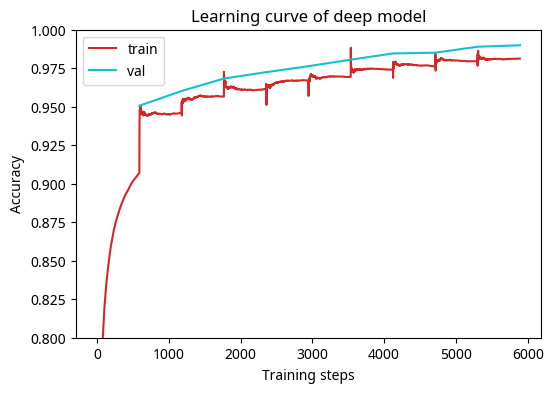

In [50]:
plot_learning_curve(acc_record, title='deep model')

# Testing

In [51]:
def df_to_tensor(dataframe):
    X = dataframe.values
    img_shape = (int) (np.sqrt(X.shape[1]))
    X = torch.tensor(X.reshape(-1, 1, img_shape, img_shape), dtype=torch.float32)
    return config['transform'](X)

mnist_test_tensor = df_to_tensor(mnist_test)
fashion_test_tensor = df_to_tensor(fashion_test)
kannada_test_tensor = df_to_tensor(kannada_test)
chinese_test_tensor = df_to_tensor(chinese_test)

In [52]:
def make_preds(tensor, model):
    preds = []
    i = 0
    while i < tensor.shape[0]:
        inputs = tensor[i:min(i + config['batch_size'], tensor.shape[0]), :, :, :]
        out = model(inputs.cuda()).cpu()
        out = torch.argmax(out,dim=1)
        out.detach().cpu()
        for t in out:
            preds.append(t.item())
        i += config['batch_size']
    return preds

In [ ]:
def print_accuracy(y_pred, y_true, name):
    print("{0:<10} Dataset Accuracy: {1:<8}".format(name, accuracy_score(y_true, y_pred)))

In [ ]:
def make_submission(preds, inputFile, target_column, outputFile):
    input_df = pd.read_csv(inputFile)
    input_df[target_column] = pd.DataFrame(preds)
    input_df.to_csv(outputFile, index=False)
    print(f"Uploading data to {outputFile}")

In [53]:
model.load_state_dict(best_val_model)
model.eval()
with torch.no_grad():
    mnist_preds = make_preds(mnist_test_tensor, model)
    fashion_preds = make_preds(fashion_test_tensor, model)
    kannada_preds = make_preds(kannada_test_tensor, model)
    chinese_preds = make_preds(chinese_test_tensor, model)

In [57]:
make_submission(mnist_preds, "data/MNIST/sample_submission.csv", "Label", "submissions/mnist_preds.csv")
# This is the accuracy we get from submitting to Kaggle
print("{0:<10} Dataset Accuracy: {1:<8}".format("MNIST", 0.99189))
print_accuracy(fashion_preds, fashion_test_labels, "Fashion")
print_accuracy(chinese_preds, chinese_test_labels, "Chinese")
print_accuracy(kannada_preds, kannada_test_labels, "Kannada")

Uploading data to submissions/mnist_preds.csv
MNIST      Dataset Accuracy: 0.99189 
Fashion    Dataset Accuracy: 0.9338  
Chinese    Dataset Accuracy: 0.9893333333333333
Kannada    Dataset Accuracy: 0.9951666666666666


<Axes: xlabel='Name'>

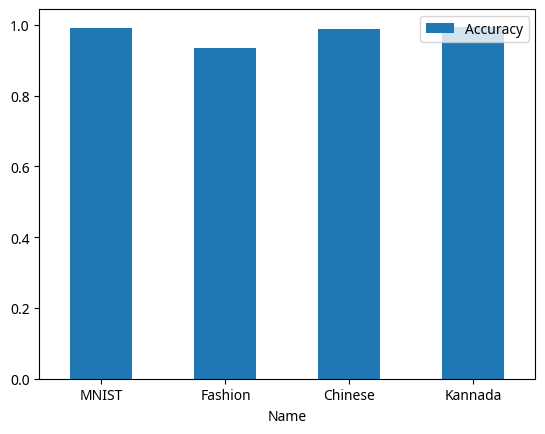

In [58]:
acc_dict = {
    "MNIST": 0.99189,
    "Fashion": accuracy_score(fashion_test_labels, fashion_preds),
    "Chinese": accuracy_score(chinese_test_labels, chinese_preds),
    "Kannada": accuracy_score(kannada_test_labels, kannada_preds),
}

acc_df = pd.DataFrame(data={'Name': list(acc_dict.keys()), 'Accuracy': list(acc_dict.values())})
acc_df.plot.bar(x='Name', y='Accuracy', rot=0)